<a href="https://colab.research.google.com/github/R-Madhuram/UC-BerkeleyCapstone_CreditCardFraudDetection/blob/main/notebooks/ensemble_methods/8_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CatBoost Classifier(s)

## Importing the Libraries

In [ ]:
# Import the libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [ ]:
!pip install catboost 
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc,RocCurveDisplay,PrecisionRecallDisplay

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import cross_validate

## Importing helper functions


In [ ]:
# Import the helper functions
# Import the required functions from the helper function file
from helper_functions_ml import createMetricsDF,computeModelMetrics,computeAndPlotMetrics

## Import the Data (training and testing)

In [ ]:
# Read the training data
df_train = pd.read_csv('df.csv')
print(df_train.head())

df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head(3)
print(df_train.shape)

   Unnamed: 0  TransactionID  isFraud  TransactionDT  TransactionAmt  \
0           0        2987000        0          86400        1.835691   
1           1        2987001        0          86401        1.462398   
2           2        2987002        0          86469        1.770852   
3           3        2987003        0          86499        1.698970   
4           4        2987004        0          86506        1.698970   

   ProductCD  card1  card2  card3  card4  ...  id_36  id_37  id_38  \
0          4  13926   -1.0  150.0      1  ...      2      2      2   
1          4   2755  404.0  150.0      2  ...      2      2      2   
2          4   4663  490.0  150.0      4  ...      2      2      2   
3          4  18132  567.0  150.0      2  ...      2      2      2   
4          1   4497  514.0  150.0      2  ...      0      1      1   

   DeviceType  DeviceInfo  P_emaildomain_addr1_card1  card1_card2  \
0           1        1735                      63363         3655   
1       

In [ ]:
# CP cannot be used to copy file here because numFolds is a variable and hence the filenames will change based on the number of folds.
# instead of using linux CP command we use SHUTIL copy 

# read the K fold train and dev indices

numFolds = 3

import shutil # file copy package. 

srcFileName = 'Classification_Products\train_dev_indices_' + str(numFolds) + '.pickle' 
train_dev_indices_file = 'train_dev_indices_' + str(numFolds) + '.pickle'
# !cp  srcFileName destFileName
shutil.copyfile(srcFileName, train_dev_indices_file)


'train_dev_indices_3.pickle'

In [ ]:
# read the train dev indices file
# train_dev_indices_df = pd.read_csv(train_dev_indices_file)
# train_dev_indices_df.head()

with open(train_dev_indices_file, 'rb') as handle:
    train_dev_indices = pickle.load(handle)
train_dev_indices

{'train': [array([195756, 195757, 195758, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 397410, 397417, 397418])],
 'dev': [array([     0,      1,      2, ..., 221151, 221172, 221182]),
  array([195756, 195757, 195758, ..., 397410, 397417, 397418]),
  array([393481, 393482, 393483, ..., 590537, 590538, 590539])]}

In [ ]:
# Getting dataready
X = df_train.drop(columns = ['isFraud','TransactionID'])
y = df_train['isFraud']

In [ ]:
# List of categorical and numerical columns in merged dataset

## Numerical columns

num_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['float64', 'int64']:
    num_column_lst_final.append(icol)
print(f"The columns that have numerical features are: '{num_column_lst_final}'")
print(f"The number of columns that have numerical features are: '{len(num_column_lst_final)}'")

print('\n')

## Categorical Columns
cat_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['object']:
    cat_column_lst_final.append(icol)
print(f"The columns that have categorical features are: '{cat_column_lst_final}'")
print(f"The number of columns that have categorical features are: '{len(cat_column_lst_final)}'")


The columns that have numerical features are: '['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D8', 'D9', 'D10', 'D13', 'D14', 'M1', 'M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V4', 'V6', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V39', 'V44', 'V46', 'V53', 'V55', 'V61', 'V66', 'V75', 'V77', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V135', 'V138', 'V139', 'V141', 'V144', 'V148', 'V161', 'V169', 'V170', 'V172', 'V173', 'V174', 'V184', 'V194', 'V208', 'V209', 'V214', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V284', 'V286', 'V288', 'V290', 'V300', 'V305', 'V313', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',

## Ensemble model(s)


### BOOSTING METHODS


#### Default Model

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred_train = {}
y_pred_dev = {}

y_pred_train_prob = {}
y_pred_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(task_type="GPU",
                                                                                  devices='0:1'))])
  pipe.fit(X_train,y_train)

  y_pred_train[i_fold] = pipe.predict(X_train)
  y_pred_dev[i_fold] = pipe.predict(X_dev)

  y_pred_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]


In [ ]:
pipe['clf_cat'].get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'iterations': 1500,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'grow_policy': 'Lossguide',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '0:1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 25,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_backtracking': 'AnyImprovement',


#### Model 2 (Hypertuning Parameters)

In [ ]:
#model 2
# loop through each fold, retrieve the train and dev ids for each fold before running the tuned catboost Classifier model on each fold
y_pred2_train = {}
y_pred2_dev = {}

y_pred2_train_prob = {}
y_pred2_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(task_type="GPU", devices='0:1',
                                                                                  num_boost_round=700,learning_rate=0.01,grow_policy='Depthwise',
                                                                                  scale_pos_weight=10, depth=15, score_function='L2', 
                                                                                  eval_metric='BalancedAccuracy'))])
                                                                                  
  pipe.fit(X_train,y_train)

  y_pred2_train[i_fold] = pipe.predict(X_train)
  y_pred2_dev[i_fold] = pipe.predict(X_dev)

  y_pred2_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred2_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]



#### Model 3

In [ ]:
# model 3
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred3_train = {}
y_pred3_dev = {}

y_pred3_train_prob = {}
y_pred3_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(task_type="GPU", devices='0:1',
                                                                                  num_boost_round=700,learning_rate=0.01,grow_policy='Depthwise',
                                                                                  scale_pos_weight=10, depth=11, score_function='L2',
                                                                                  l2_leaf_reg = 4.0,min_data_in_leaf=32, eval_metric='AUC'
                                                                                  ))])
                                                                                  
  pipe.fit(X_train,y_train)

  y_pred3_train[i_fold] = pipe.predict(X_train)
  y_pred3_dev[i_fold] = pipe.predict(X_dev)

  y_pred3_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred3_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]



Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 80ms	remaining: 55.9s
1:	total: 177ms	remaining: 1m 1s
2:	total: 257ms	remaining: 59.8s
3:	total: 321ms	remaining: 55.9s
4:	total: 376ms	remaining: 52.3s
5:	total: 443ms	remaining: 51.2s
6:	total: 497ms	remaining: 49.2s
7:	total: 546ms	remaining: 47.2s
8:	total: 585ms	remaining: 45s
9:	total: 633ms	remaining: 43.7s
10:	total: 676ms	remaining: 42.3s
11:	total: 725ms	remaining: 41.6s
12:	total: 768ms	remaining: 40.6s
13:	total: 817ms	remaining: 40s
14:	total: 867ms	remaining: 39.6s
15:	total: 913ms	remaining: 39s
16:	total: 961ms	remaining: 38.6s
17:	total: 1.01s	remaining: 38.3s
18:	total: 1.05s	remaining: 37.8s
19:	total: 1.1s	remaining: 37.4s
20:	total: 1.16s	remaining: 37.5s
21:	total: 1.2s	remaining: 37s
22:	total: 1.25s	remaining: 36.7s
23:	total: 1.29s	remaining: 36.3s
24:	total: 1.33s	remaining: 36s
25:	total: 1.38s	remaining: 35.7s
26:	total: 1.42s	remaining: 35.5s
27:	total: 1.47s	remaining: 35.2s
28:	total: 1.51s	remaining: 34.9s
29:	total: 1.56s	remaining: 34.9s
30:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 84.4ms	remaining: 59s
1:	total: 163ms	remaining: 57s
2:	total: 242ms	remaining: 56.2s
3:	total: 312ms	remaining: 54.3s
4:	total: 372ms	remaining: 51.7s
5:	total: 422ms	remaining: 48.8s
6:	total: 476ms	remaining: 47.1s
7:	total: 549ms	remaining: 47.5s
8:	total: 595ms	remaining: 45.7s
9:	total: 637ms	remaining: 44s
10:	total: 686ms	remaining: 43s
11:	total: 725ms	remaining: 41.6s
12:	total: 777ms	remaining: 41s
13:	total: 821ms	remaining: 40.2s
14:	total: 867ms	remaining: 39.6s
15:	total: 915ms	remaining: 39.1s
16:	total: 960ms	remaining: 38.6s
17:	total: 1.01s	remaining: 38.2s
18:	total: 1.05s	remaining: 37.5s
19:	total: 1.09s	remaining: 37.1s
20:	total: 1.14s	remaining: 36.7s
21:	total: 1.19s	remaining: 36.7s
22:	total: 1.24s	remaining: 36.5s
23:	total: 1.28s	remaining: 36.2s
24:	total: 1.32s	remaining: 35.8s
25:	total: 1.39s	remaining: 35.9s
26:	total: 1.43s	remaining: 35.7s
27:	total: 1.48s	remaining: 35.4s
28:	total: 1.52s	remaining: 35.3s
29:	total: 1.59s	remaining: 35.5s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 223ms	remaining: 2m 36s
1:	total: 430ms	remaining: 2m 30s
2:	total: 638ms	remaining: 2m 28s
3:	total: 846ms	remaining: 2m 27s
4:	total: 1.04s	remaining: 2m 24s
5:	total: 1.14s	remaining: 2m 11s
6:	total: 1.23s	remaining: 2m 1s
7:	total: 1.3s	remaining: 1m 52s
8:	total: 1.36s	remaining: 1m 44s
9:	total: 1.41s	remaining: 1m 37s
10:	total: 1.47s	remaining: 1m 32s
11:	total: 1.51s	remaining: 1m 26s
12:	total: 1.57s	remaining: 1m 22s
13:	total: 1.61s	remaining: 1m 18s
14:	total: 1.65s	remaining: 1m 15s
15:	total: 1.7s	remaining: 1m 12s
16:	total: 1.75s	remaining: 1m 10s
17:	total: 1.81s	remaining: 1m 8s
18:	total: 1.85s	remaining: 1m 6s
19:	total: 1.9s	remaining: 1m 4s
20:	total: 1.94s	remaining: 1m 2s
21:	total: 1.99s	remaining: 1m 1s
22:	total: 2.04s	remaining: 1m
23:	total: 2.1s	remaining: 59.2s
24:	total: 2.15s	remaining: 58s
25:	total: 2.21s	remaining: 57.3s
26:	total: 2.26s	remaining: 56.3s
27:	total: 2.3s	remaining: 55.3s
28:	total: 2.35s	remaining: 54.4s
29:	total: 2.39s	r

#### Model 4

In [ ]:
# model 4
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred4_train = {}
y_pred4_dev = {}

y_pred4_train_prob = {}
y_pred4_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(task_type="GPU", devices='0:1',
                                                                                  num_boost_round=300,learning_rate=0.01,grow_policy='Depthwise',
                                                                                  scale_pos_weight=10, depth=15, score_function='L2', 
                                                                                  eval_metric='AUC', bootstrap_type='Poisson',
                                                                                  subsample=0.8))])
                                                                                  
  pipe.fit(X_train,y_train)

  y_pred4_train[i_fold] = pipe.predict(X_train)
  y_pred4_dev[i_fold] = pipe.predict(X_dev)

  y_pred4_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred4_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]



#### Random Search 1

In [ ]:
# X = df_train.drop('isFraud', axis=1)
# y = df_train['isFraud']

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# model1 

random_model1 = CatBoostClassifier(loss_function='Logloss')

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10, 15],
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         'stratified':[True],
#         'cv':[3,5],
#         'train_size':[0.5,0.8],
#         'grow_policy':['Depthwise', 'Plain'],
#         'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']}

grid = {'learning_rate': [0.03,0.1]}

randomized_search_result1 = random_model1.randomized_search(grid,
                                                   X=X,
                                                   y=y,train_size=0.7,cv=3,plot=True)

In [ ]:
# model random 1
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred_rand1_train = {}
y_pred_rand1_dev = {}

y_pred_rand1_train_prob = {}
y_pred_rand1_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(
                                                                                  num_boost_round=700,learning_rate=0.1,grow_policy='Depthwise',
                                                                                  scale_pos_weight=10, depth=15, score_function='L2', 
                                                                                  eval_metric='BalancedAccuracy'))])
                                                                                  
  pipe.fit(X_train,y_train)

  y_pred_rand1_train[i_fold] = pipe.predict(X_train)
  y_pred_rand1_dev[i_fold] = pipe.predict(X_dev)

  y_pred_rand1_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred_rand1_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]



#### SMOTE sampled

In [ ]:
# Install imbalanced learn within the conda environment
!pip install --upgrade imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 17.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
# SMOTE Sampling for the imbalanced dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
numFolds = 3
skf = StratifiedKFold(n_splits=numFolds)

In [ ]:
from math import sqrt

y_pred6_train = {}  
y_pred6_dev = {}

y_pred6_train_prob = {}
y_pred6_dev_prob = {}

y_train_folds_smote = {}
y_dev_folds_smote ={}

i_fold=0

for train, dev in skf.split(X_smote, y_smote):
  X_train = X_smote.loc[train,:]
  X_dev = X_smote.loc[dev,:]

  y_train = y_smote[train]
  y_dev = y_smote[dev]

  y_train_folds_smote[i_fold] = y_train
  y_dev_folds_smote[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_smote = Pipeline([('preprocessor', preprocessor), 
                         ('clf_cat', CatBoostClassifier(task_type="GPU", 
                                                       devices='0:1',
                                                       num_boost_round=300,
                                                       learning_rate=0.01,
                                                       grow_policy='Depthwise',
                                                       scale_pos_weight=10, 
                                                       depth=15, score_function='L2', 
                                                       eval_metric='AUC', 
                                                       bootstrap_type='Poisson',
                                                       subsample=0.8,
                                                       random_seed=42))
                       ])
  pipe_smote.fit(X_train,y_train)

  y_pred6_train[i_fold] = pipe_smote.predict(X_train)
  y_pred6_dev[i_fold] = pipe_smote.predict(X_dev)

  y_pred6_train_prob[i_fold] = pipe_smote.predict_proba(X_train)[:,1]
  y_pred6_dev_prob[i_fold] = pipe_smote.predict_proba(X_dev)[:,1]

  i_fold+=1


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 456ms	remaining: 2m 16s
1:	total: 1.07s	remaining: 2m 39s
2:	total: 1.9s	remaining: 3m 7s
3:	total: 2.8s	remaining: 3m 27s
4:	total: 3.47s	remaining: 3m 24s
5:	total: 4.33s	remaining: 3m 32s
6:	total: 4.99s	remaining: 3m 28s
7:	total: 5.35s	remaining: 3m 15s
8:	total: 5.57s	remaining: 3m
9:	total: 5.87s	remaining: 2m 50s
10:	total: 6.2s	remaining: 2m 42s
11:	total: 6.5s	remaining: 2m 35s
12:	total: 6.88s	remaining: 2m 31s
13:	total: 7.34s	remaining: 2m 30s
14:	total: 7.69s	remaining: 2m 26s
15:	total: 7.97s	remaining: 2m 21s
16:	total: 8.31s	remaining: 2m 18s
17:	total: 8.46s	remaining: 2m 12s
18:	total: 8.61s	remaining: 2m 7s
19:	total: 8.77s	remaining: 2m 2s
20:	total: 8.92s	remaining: 1m 58s
21:	total: 9.09s	remaining: 1m 54s
22:	total: 9.25s	remaining: 1m 51s
23:	total: 9.42s	remaining: 1m 48s
24:	total: 9.6s	remaining: 1m 45s
25:	total: 9.77s	remaining: 1m 42s
26:	total: 9.95s	remaining: 1m 40s
27:	total: 10.1s	remaining: 1m 38s
28:	total: 10.3s	remaining: 1m 36s
29:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 483ms	remaining: 2m 24s
1:	total: 890ms	remaining: 2m 12s
2:	total: 1.2s	remaining: 1m 58s
3:	total: 1.52s	remaining: 1m 52s
4:	total: 1.88s	remaining: 1m 50s
5:	total: 2.22s	remaining: 1m 48s
6:	total: 2.59s	remaining: 1m 48s
7:	total: 2.92s	remaining: 1m 46s
8:	total: 3.23s	remaining: 1m 44s
9:	total: 3.46s	remaining: 1m 40s
10:	total: 3.67s	remaining: 1m 36s
11:	total: 3.89s	remaining: 1m 33s
12:	total: 4.11s	remaining: 1m 30s
13:	total: 4.35s	remaining: 1m 28s
14:	total: 4.57s	remaining: 1m 26s
15:	total: 4.79s	remaining: 1m 25s
16:	total: 5.02s	remaining: 1m 23s
17:	total: 5.27s	remaining: 1m 22s
18:	total: 5.51s	remaining: 1m 21s
19:	total: 5.73s	remaining: 1m 20s
20:	total: 5.99s	remaining: 1m 19s
21:	total: 6.23s	remaining: 1m 18s
22:	total: 6.46s	remaining: 1m 17s
23:	total: 6.71s	remaining: 1m 17s
24:	total: 6.94s	remaining: 1m 16s
25:	total: 7.21s	remaining: 1m 15s
26:	total: 7.47s	remaining: 1m 15s
27:	total: 7.73s	remaining: 1m 15s
28:	total: 8s	remaining: 1m 14s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 273ms	remaining: 1m 21s
1:	total: 479ms	remaining: 1m 11s
2:	total: 651ms	remaining: 1m 4s
3:	total: 822ms	remaining: 1m
4:	total: 1s	remaining: 59.1s
5:	total: 1.19s	remaining: 58.4s
6:	total: 1.37s	remaining: 57.2s
7:	total: 1.56s	remaining: 56.9s
8:	total: 1.74s	remaining: 56.2s
9:	total: 1.94s	remaining: 56.2s
10:	total: 2.23s	remaining: 58.5s
11:	total: 2.54s	remaining: 1m
12:	total: 2.9s	remaining: 1m 3s
13:	total: 3.26s	remaining: 1m 6s
14:	total: 3.62s	remaining: 1m 8s
15:	total: 3.97s	remaining: 1m 10s
16:	total: 4.34s	remaining: 1m 12s
17:	total: 4.71s	remaining: 1m 13s
18:	total: 5.08s	remaining: 1m 15s
19:	total: 5.42s	remaining: 1m 15s
20:	total: 5.79s	remaining: 1m 16s
21:	total: 6.12s	remaining: 1m 17s
22:	total: 6.4s	remaining: 1m 17s
23:	total: 6.63s	remaining: 1m 16s
24:	total: 6.84s	remaining: 1m 15s
25:	total: 7.03s	remaining: 1m 14s
26:	total: 7.24s	remaining: 1m 13s
27:	total: 7.44s	remaining: 1m 12s
28:	total: 7.67s	remaining: 1m 11s
29:	total: 7.9s	rem

#### SMOTE Training sampled

In [ ]:
y_pred7_train = {}  
y_pred7_dev = {}

y_pred7_train_prob = {}
y_pred7_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

i_fold=0

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]

  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  X_smote, y_smote = smote.fit_resample(X_train, y_train)

  scale_pos_weight = sqrt(np.count_nonzero(y_smote==0)/np.count_nonzero(y_smote))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_training_smote = Pipeline([('preprocessor', preprocessor), 
                         ('clf_cat', CatBoostClassifier(task_type="GPU", 
                                                       devices='0:1',
                                                       num_boost_round=300,
                                                       learning_rate=0.01,
                                                       grow_policy='Depthwise',
                                                       scale_pos_weight=10, 
                                                       depth=15, score_function='L2', 
                                                       eval_metric='AUC', 
                                                       bootstrap_type='Poisson',
                                                       subsample=0.8,
                                                       random_seed=42))
                       ])
  pipe_training_smote.fit(X_train,y_train)

  y_pred7_train[i_fold] = pipe_training_smote.predict(X_train)
  y_pred7_dev[i_fold] = pipe_training_smote.predict(X_dev)

  y_pred7_train_prob[i_fold] = pipe_training_smote.predict_proba(X_train)[:,1]
  y_pred7_dev_prob[i_fold] = pipe_training_smote.predict_proba(X_dev)[:,1]

  i_fold+=1


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 201ms	remaining: 1m
1:	total: 336ms	remaining: 50.1s
2:	total: 456ms	remaining: 45.1s
3:	total: 557ms	remaining: 41.2s
4:	total: 699ms	remaining: 41.3s
5:	total: 829ms	remaining: 40.6s
6:	total: 940ms	remaining: 39.3s
7:	total: 1.05s	remaining: 38.4s
8:	total: 1.23s	remaining: 39.9s
9:	total: 1.46s	remaining: 42.4s
10:	total: 1.72s	remaining: 45.2s
11:	total: 1.99s	remaining: 47.8s
12:	total: 2.25s	remaining: 49.6s
13:	total: 2.46s	remaining: 50.3s
14:	total: 2.73s	remaining: 51.9s
15:	total: 2.96s	remaining: 52.6s
16:	total: 3.21s	remaining: 53.5s
17:	total: 3.45s	remaining: 54.1s
18:	total: 3.71s	remaining: 54.8s
19:	total: 3.95s	remaining: 55.3s
20:	total: 4.2s	remaining: 55.8s
21:	total: 4.46s	remaining: 56.3s
22:	total: 4.72s	remaining: 56.8s
23:	total: 4.97s	remaining: 57.2s
24:	total: 5.18s	remaining: 57s
25:	total: 5.39s	remaining: 56.8s
26:	total: 5.57s	remaining: 56.3s
27:	total: 5.69s	remaining: 55.3s
28:	total: 5.83s	remaining: 54.4s
29:	total: 5.94s	remaining: 53

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 208ms	remaining: 1m 2s
1:	total: 366ms	remaining: 54.5s
2:	total: 484ms	remaining: 47.9s
3:	total: 617ms	remaining: 45.7s
4:	total: 730ms	remaining: 43.1s
5:	total: 840ms	remaining: 41.1s
6:	total: 962ms	remaining: 40.3s
7:	total: 1.07s	remaining: 39.2s
8:	total: 1.21s	remaining: 39s
9:	total: 1.33s	remaining: 38.6s
10:	total: 1.45s	remaining: 38.2s
11:	total: 1.58s	remaining: 37.8s
12:	total: 1.7s	remaining: 37.6s
13:	total: 1.81s	remaining: 37s
14:	total: 1.92s	remaining: 36.6s
15:	total: 2.05s	remaining: 36.3s
16:	total: 2.17s	remaining: 36.1s
17:	total: 2.29s	remaining: 35.8s
18:	total: 2.41s	remaining: 35.7s
19:	total: 2.54s	remaining: 35.5s
20:	total: 2.65s	remaining: 35.3s
21:	total: 2.77s	remaining: 35s
22:	total: 2.89s	remaining: 34.8s
23:	total: 3.02s	remaining: 34.8s
24:	total: 3.15s	remaining: 34.6s
25:	total: 3.27s	remaining: 34.5s
26:	total: 3.4s	remaining: 34.4s
27:	total: 3.52s	remaining: 34.2s
28:	total: 3.67s	remaining: 34.3s
29:	total: 3.8s	remaining: 34.2s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 204ms	remaining: 1m
1:	total: 336ms	remaining: 50.1s
2:	total: 451ms	remaining: 44.6s
3:	total: 551ms	remaining: 40.8s
4:	total: 656ms	remaining: 38.7s
5:	total: 780ms	remaining: 38.2s
6:	total: 891ms	remaining: 37.3s
7:	total: 1.02s	remaining: 37.3s
8:	total: 1.14s	remaining: 36.9s
9:	total: 1.26s	remaining: 36.5s
10:	total: 1.38s	remaining: 36.2s
11:	total: 1.49s	remaining: 35.7s
12:	total: 1.61s	remaining: 35.5s
13:	total: 1.74s	remaining: 35.4s
14:	total: 1.87s	remaining: 35.5s
15:	total: 2s	remaining: 35.4s
16:	total: 2.11s	remaining: 35.1s
17:	total: 2.22s	remaining: 34.8s
18:	total: 2.34s	remaining: 34.6s
19:	total: 2.45s	remaining: 34.3s
20:	total: 2.58s	remaining: 34.2s
21:	total: 2.69s	remaining: 34s
22:	total: 2.81s	remaining: 33.8s
23:	total: 2.94s	remaining: 33.8s
24:	total: 3.07s	remaining: 33.8s
25:	total: 3.2s	remaining: 33.7s
26:	total: 3.31s	remaining: 33.5s
27:	total: 3.44s	remaining: 33.5s
28:	total: 3.57s	remaining: 33.3s
29:	total: 3.68s	remaining: 33.1s

## Evaluation of the model(s)

### Default Model

In [ ]:
thresholds = np.arange(0, 1, .05)

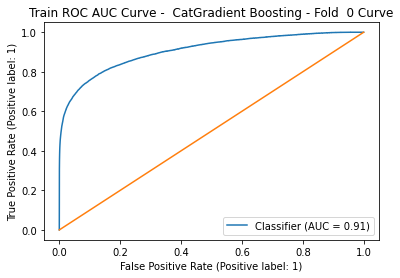

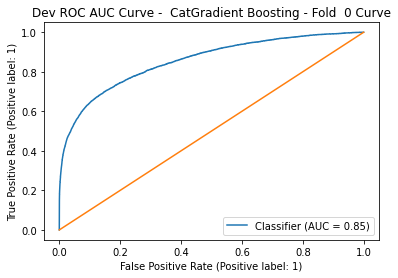

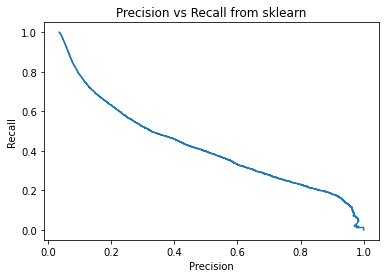

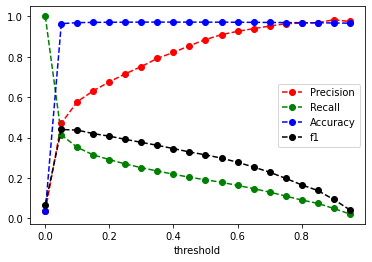

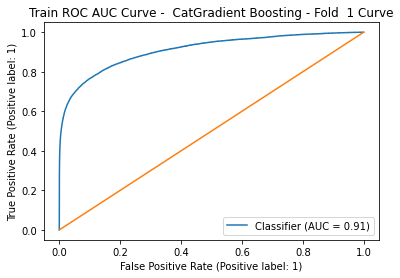

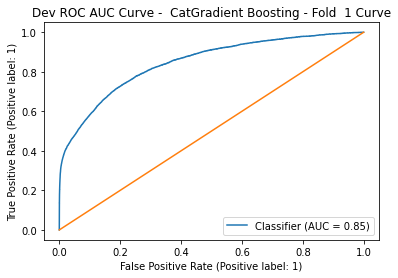

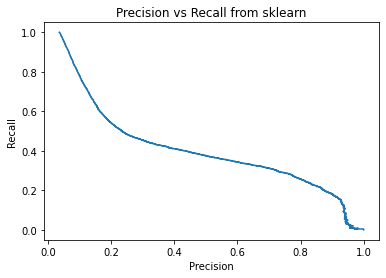

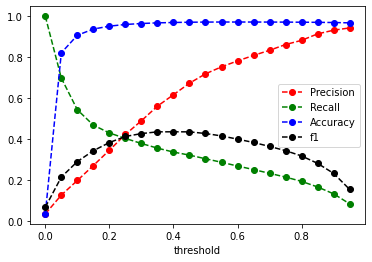

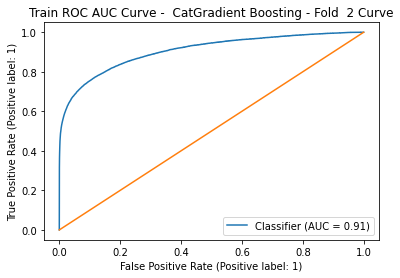

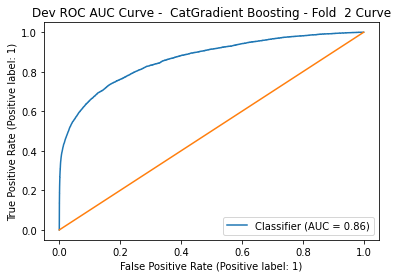

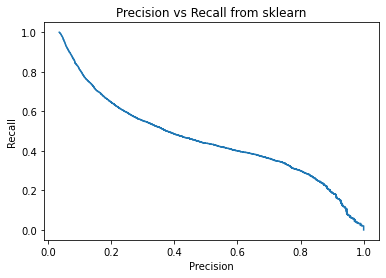

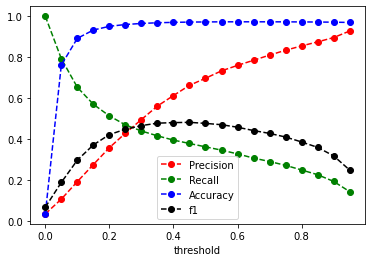

In [ ]:
# Basic Catboost
catb_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb_metrics_DF.append(computeAndPlotMetrics(y_pred_train[i_fold],y_pred_train_prob[i_fold],
                              y_pred_dev[i_fold],y_pred_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting - Fold  ' + str(i_fold) ))


### Model 2

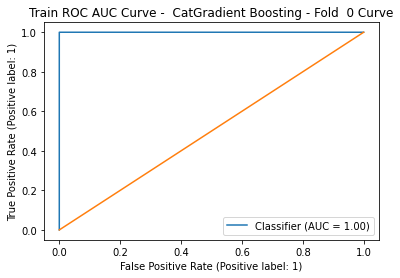

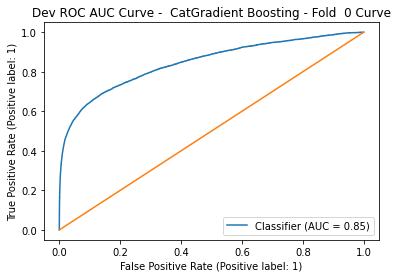

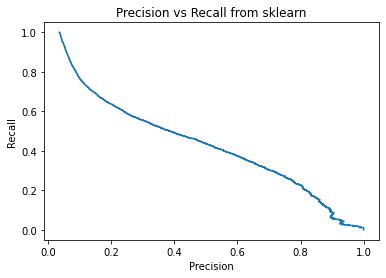

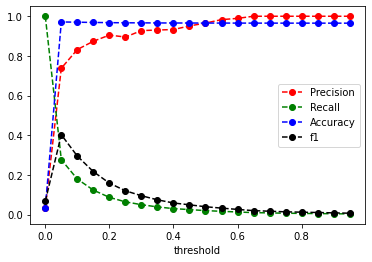

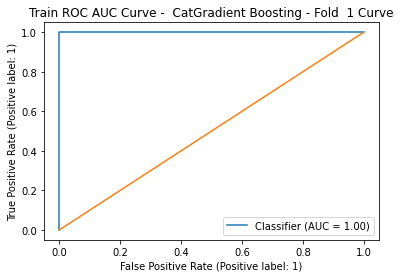

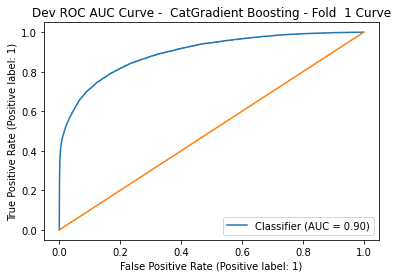

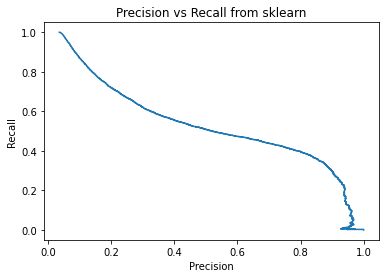

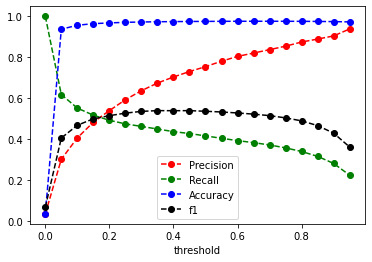

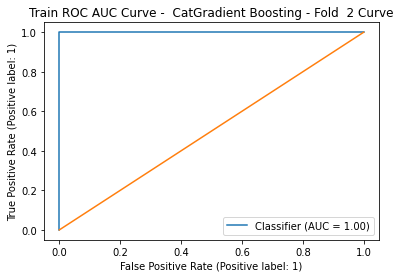

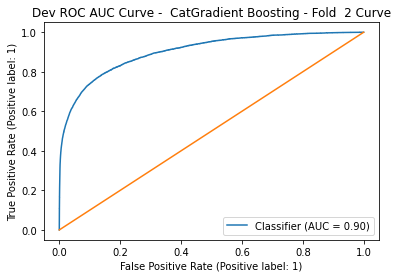

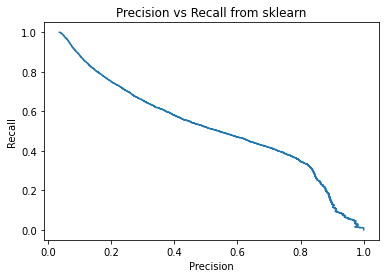

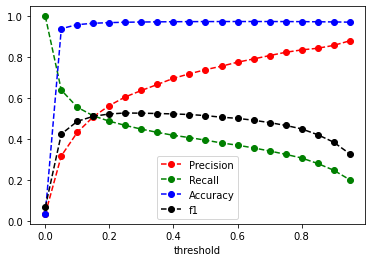

In [ ]:
# model 2 with tuning parameters
catb2_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb2_metrics_DF.append(computeAndPlotMetrics(y_pred2_train[i_fold],y_pred2_train_prob[i_fold],
                              y_pred2_dev[i_fold],y_pred2_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting2 - Fold  ' + str(i_fold) ))



### Model 3

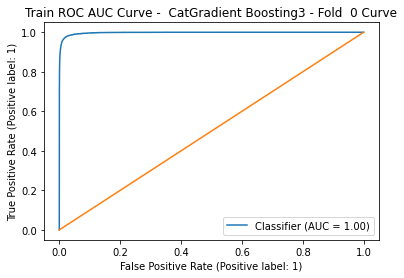

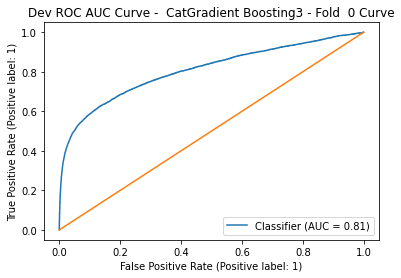

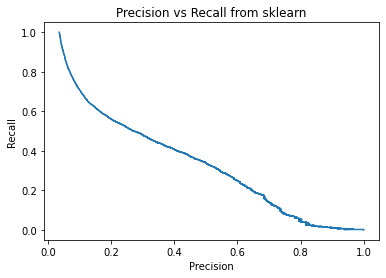

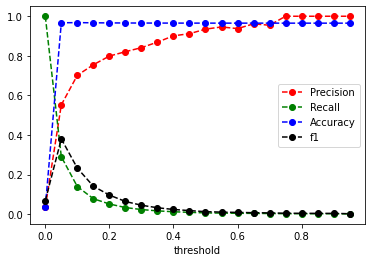

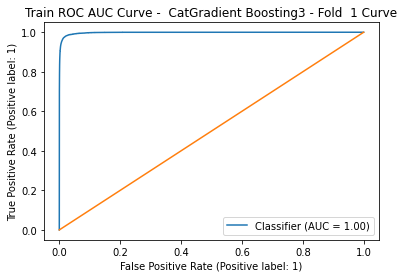

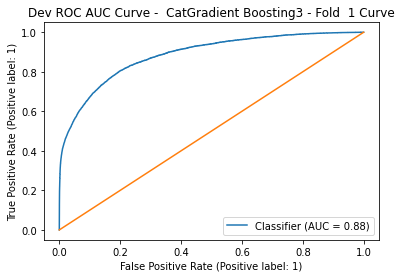

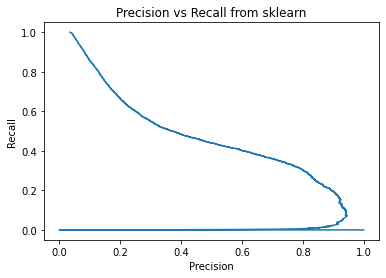

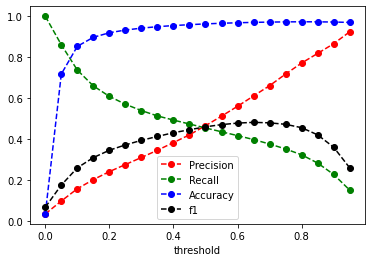

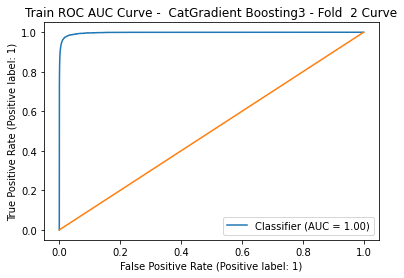

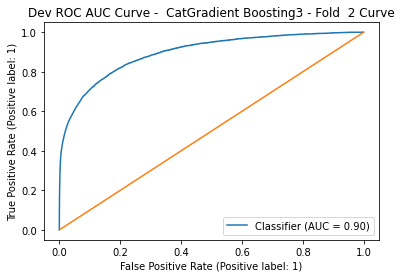

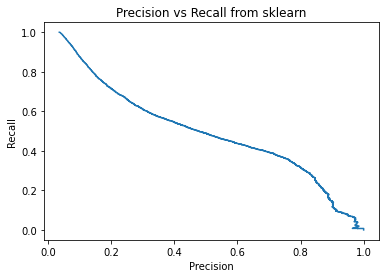

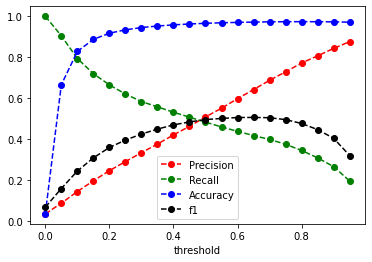

In [ ]:
# model 3 with tuning parameters
catb3_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb3_metrics_DF.append(computeAndPlotMetrics(y_pred3_train[i_fold],y_pred3_train_prob[i_fold],
                              y_pred3_dev[i_fold],y_pred3_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting3 - Fold  ' + str(i_fold) ))



### Model 4

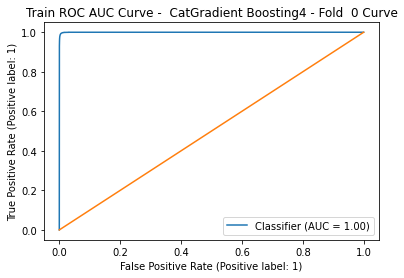

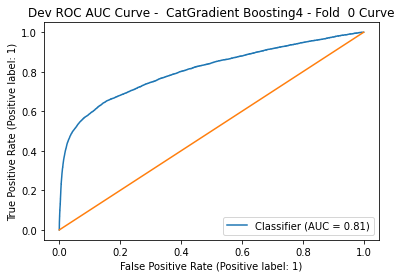

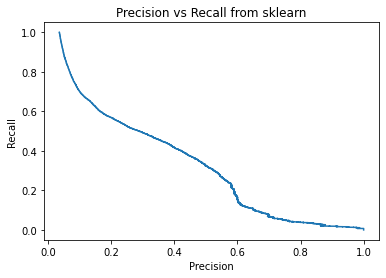

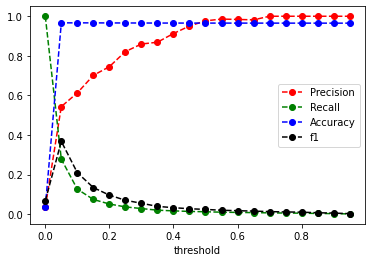

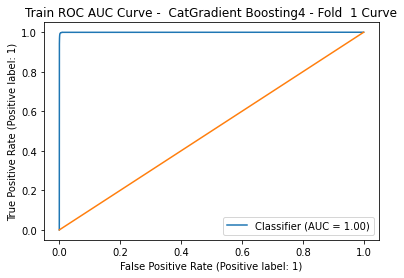

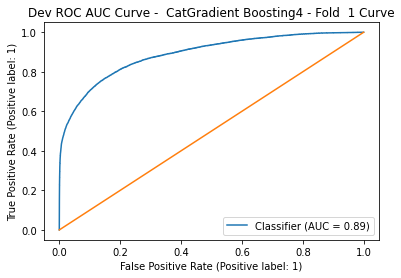

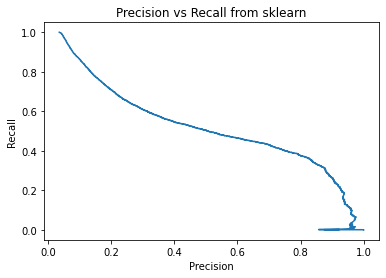

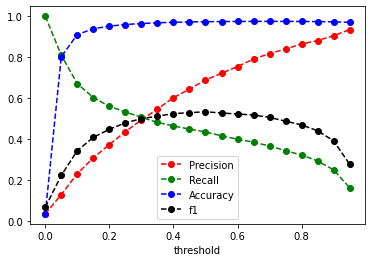

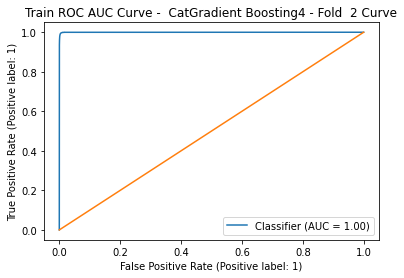

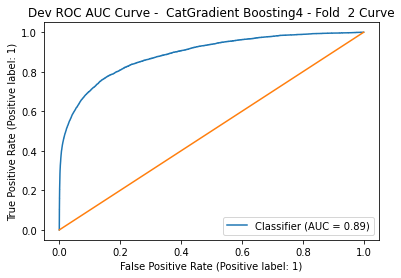

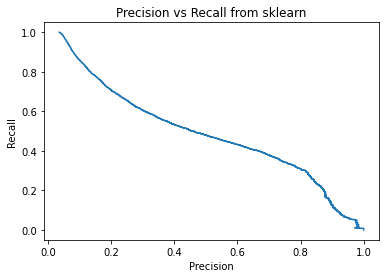

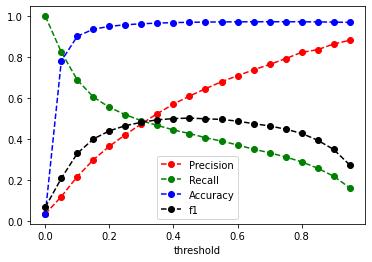

In [ ]:
# model 4 with tuning parameters
catb4_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb4_metrics_DF.append(computeAndPlotMetrics(y_pred4_train[i_fold],y_pred4_train_prob[i_fold],
                              y_pred4_dev[i_fold],y_pred4_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting4 - Fold  ' + str(i_fold) ))



### Random Search 1

In [ ]:
# model 5 with tuning parameters
catb_rand1_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb_rand1_metrics_DF.append(computeAndPlotMetrics(y_pred_rand1_train[i_fold],y_pred_rand1_train_prob[i_fold],
                              y_pred_rand1_dev[i_fold],y_pred_rand1_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting Random Search - Fold  ' + str(i_fold) ))



### SMOTE Sampled

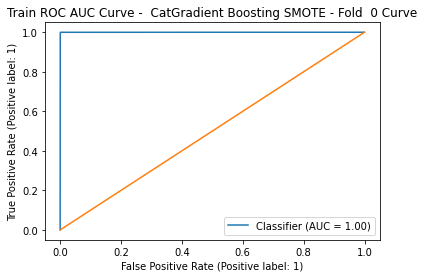

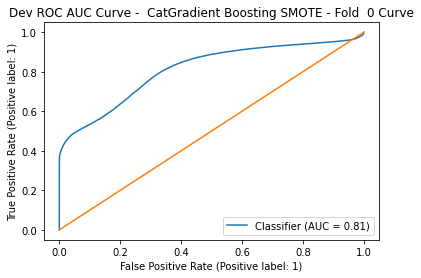

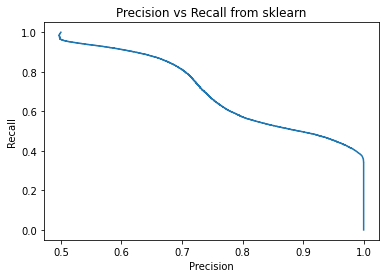

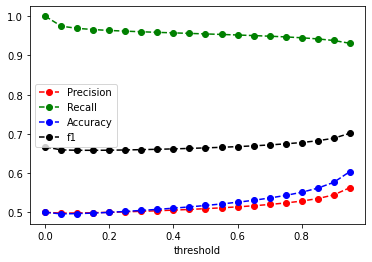

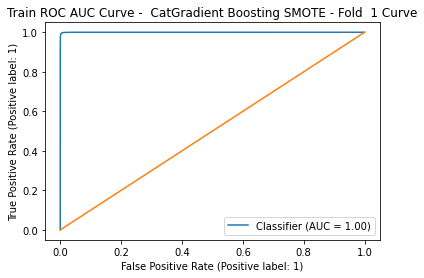

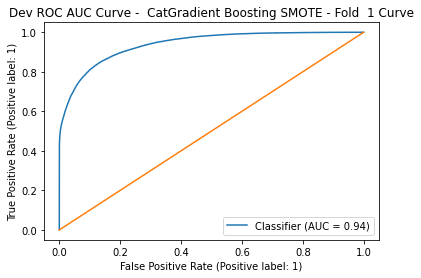

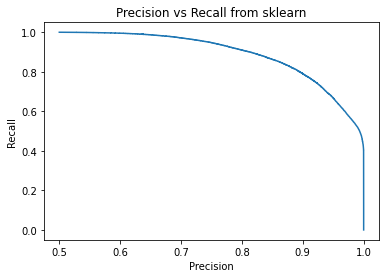

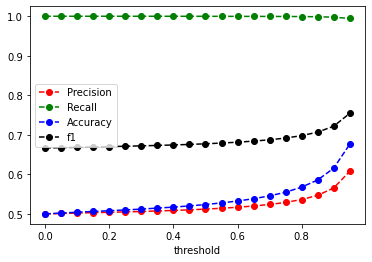

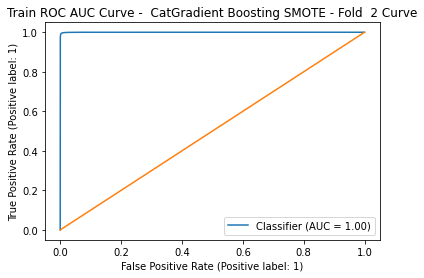

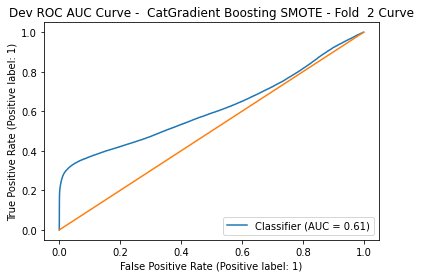

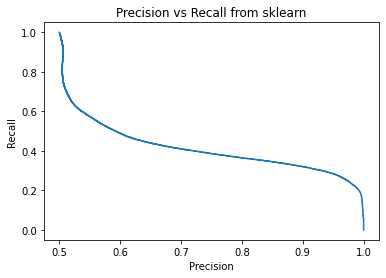

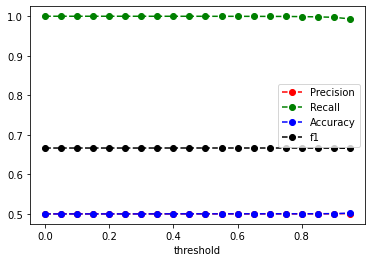

In [ ]:
# model 6 with tuning parameters
catb_smote_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb_smote_metrics_DF.append(computeAndPlotMetrics(y_pred6_train[i_fold],y_pred6_train_prob[i_fold],
                              y_pred6_dev[i_fold],y_pred6_dev_prob[i_fold],
                                  y_dev_folds_smote[i_fold],y_train_folds_smote[i_fold],thresholds,
                                  'CatGradient Boosting SMOTE - Fold  ' + str(i_fold) ))



### SMOTE Training Sampled

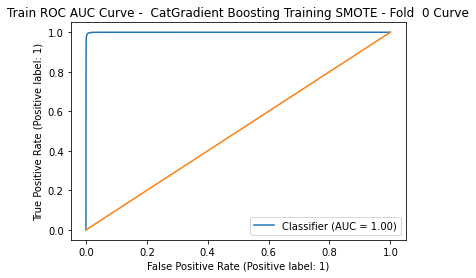

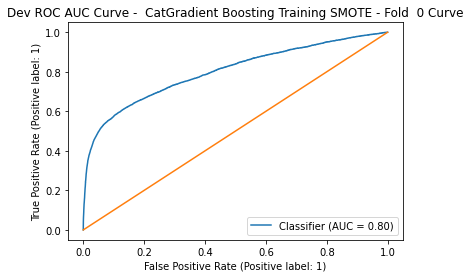

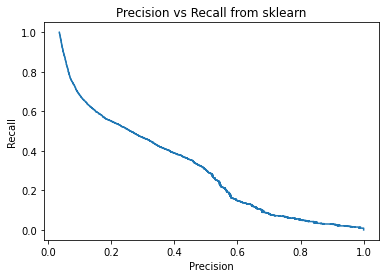

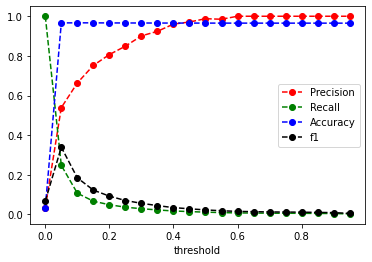

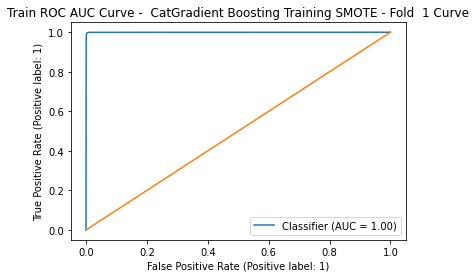

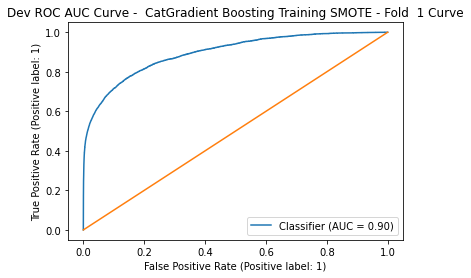

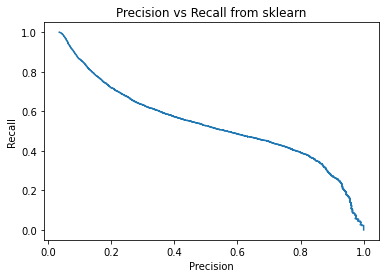

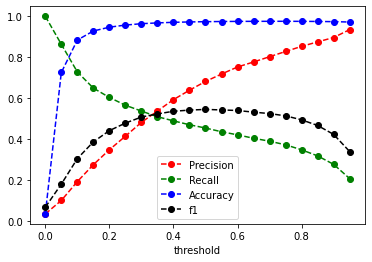

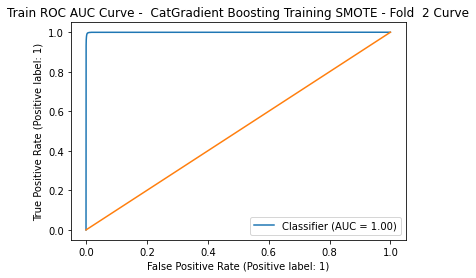

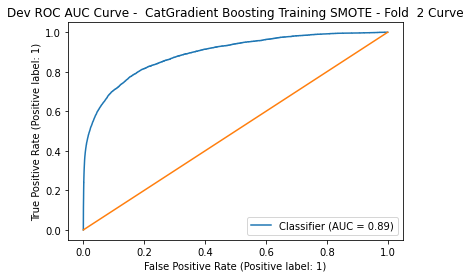

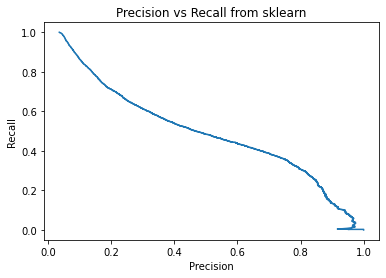

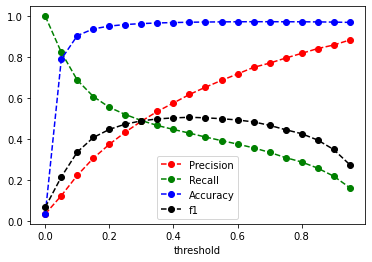

In [ ]:
# model 7 with tuning parameters
catb_training_smote_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb_training_smote_metrics_DF.append(computeAndPlotMetrics(y_pred7_train[i_fold],y_pred7_train_prob[i_fold],
                              y_pred7_dev[i_fold],y_pred7_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting Training SMOTE - Fold  ' + str(i_fold) ))



# Summary

In [ ]:
catb_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.977383  0.542117   0.929466  0.382650       0.906692
 1  development  0.970820  0.314231   0.884409  0.191057       0.854706,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.976875  0.527703   0.924559  0.369220       0.910290
 1  development  0.971491  0.427581   0.718793  0.304297       0.845991,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.977470  0.542689   0.936477  0.382041       0.905860
 1  development  0.972186  0.476927   0.697207  0.362422       0.864938]

In [ ]:
catb2_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999982  0.999746   0.999492  1.000000       1.000000
 1  development  0.965694  0.039812   0.965517  0.020325       0.845697,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999990  0.999855   0.999710  1.000000        1.00000
 1  development  0.974813  0.536115   0.753947  0.415941        0.89614,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999985  0.999782   0.999565  1.000000       1.000000
 1  development  0.973959  0.515043   0.739071  0.395237       0.903307]

In [ ]:
catb3_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.993033  0.902332   0.885465  0.919855       0.997660
 1  development  0.965227  0.012978   0.957447  0.006533       0.817206,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.993612  0.910278   0.894921  0.926171       0.998068
 1  development  0.962641  0.460059   0.465389  0.454849       0.884825,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.993470  0.907767   0.897369  0.918409       0.997841
 1  development  0.965623  0.496391   0.509160  0.484246       0.896688]

In [ ]:
catb4_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.997793  0.968690   0.961588  0.975898       0.999813
 1  development  0.965425  0.024089   0.976744  0.012195       0.807133,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.998265  0.975376   0.968844  0.981996       0.999895
 1  development  0.973370  0.533547   0.689195  0.435250       0.889613,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training   0.99791  0.970221   0.967246  0.973214       0.999858
 1  development   0.97145  0.499466   0.645934  0.407144       0.889020]

In [ ]:
catb_smote_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.998293  0.998296   0.996629  0.999968       0.999990
 1  development  0.517335  0.664258   0.509244  0.954943       0.810581,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.992763  0.992807   0.986844  0.998842       0.999894
 1  development  0.523737  0.677347   0.512159  0.999821       0.938140,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.991982  0.992033   0.985773  0.998373       0.999880
 1  development  0.500226  0.666738   0.500113  0.999868       0.613883]

In [ ]:
catb_training_smote_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.997744  0.967998   0.961139  0.974955       0.999807
 1  development  0.965410  0.022959   0.987654  0.011614       0.800563,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.998321  0.976150   0.970373  0.981996       0.999896
 1  development  0.973482  0.545217   0.681699  0.454268       0.895443,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.997866  0.969611   0.966465  0.972779       0.999849
 1  development  0.971760  0.504059   0.653633  0.410193       0.891983]

In this notebook, we implemented the CatBoosting technique to enhance ROC-AUC scores compared to simpler classification models like Logistic Regression and Decision Trees.

Initially, we began with the default method and then proceeded with hyperparameter tuning to refine the results. Model 2 emerged as the most promising, exhibiting the best results with a comparable AUC score to other high-performing models and a significantly higher recall score.

It's worth noting that employing random search with CatBoost Classifier for hyperparameter tuning was computationally expensive, and thus, the results have not been presented here.

Additionally, the SMOTE sampled model that achieved the highest ROC-AUC score likely suffered from overfitting. The synthetic data points generated by SMOTE were present in both the training and development sets, potentially causing the model to overlearn these samples and inflate its score.

This overfitting issue was further highlighted in the next model, SMOTE Training sampled model, where SMOTE sampling was applied only to the training set. Despite this adjustment, the ROC-AUC score remained comparable to other models, suggesting a more reliable performance.

Therefore, we select Model 2 for further analysis, considering its robust performance metrics and potential avoidance of overfitting issues.